# Model Training & Evaluation

In [52]:
import torch
from config import *
from os import path
import utils
utils.set_device()
utils.set_seed()

# Dataset & Dataloaders
from data.dataset import LeakAnomalyDetectionDataset
from data.data_loaders import get_autoencoder_data_loaders, get_classifier_data_loaders

# Models
from models.classifiers  import RNNClassifier, CNNRNNClassifier
from models.autoencoders import HiddenStateRepeatedAutoencoder, ScheduledSamplingAutoencoder

# Training & Hyperparameter Optimization
from train import fit_model
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances



Using device = cpu


[autoreload of models.classifiers failed: Traceback (most recent call last):
  File "/home/nikas/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/nikas/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nikas/projects/irrigo/ml-model/src/models/classifiers.py", line 63, in <module>
    class CNNRNNClassifier(RNNClassfier):
NameError: name 'RNNClassfier' is not defined. Did you mean: 'RNNClassifier'?
]


## Training

In [53]:

leaks_dataset = LeakAnomalyDetectionDataset(normal_data_dir=NORMAL_DATA, anomalous_data_dir=ANOMALOUS_DATA)
INPUT_DIM = leaks_dataset.num_features

class SaveBestTrial:
    def __init__(self, save_dir=MODELS_DIR):
        self.save_dir = save_dir
    
    def __call__(self, study: optuna.Study, trial: optuna.Trial):
        # Check if this trial has the best result so far
        if study.best_trial.number == trial.number:
            
            model_data = {
                "model_state_dict": trial.user_attrs["model_state_dict"],
                "optimizer_state_dict": trial.user_attrs["optimizer_state_dict"],
                "history": trial.user_attrs["history"],
                "hyperparameters": trial.user_attrs["hyperparameters"]
            }
            print(trial.user_attrs["model_name"])
            model_path = path.join(self.save_dir, trial.user_attrs["model_name"] + ".pth")
            torch.save(model_data, model_path)
            print(f"Best model saved to {model_path}")

def objective(trial: optuna.trial.Trial):
    
    lr = trial.suggest_float('learning_rate', 1e-3, 1, log=True)
    dropout = trial.suggest_float('dropout', 1e-1, 0.5, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 4, 64, step=4)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    # Get data loaders
    train_loader, val_loader, _ = get_classifier_data_loaders(leaks_dataset, BATCH_SIZE)
    
    # define model
    model = RNNClassifier(input_dim=INPUT_DIM, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    model.save_hyperparameters(learning_rate=lr, batch_size=BATCH_SIZE, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    
    history = fit_model(model, train_loader, val_loader, show_progress_bar=False)

    trial.set_user_attr("model_name", type(model).__name__)
    trial.set_user_attr("model_state_dict", model.state_dict())
    trial.set_user_attr("optimizer_state_dict", model.optimizer.state_dict())
    trial.set_user_attr("hyperparameters", model.hparams)
    trial.set_user_attr("history", history)
    
    # Calculate metrics instead for leak classifcation (false-alarm-rate, accuracy, etc.)

    return history['val_loss'][-1]

save_best_trial = SaveBestTrial()

study = optuna.create_study(direction="minimize")  # Create a new study.
study.optimize(objective, n_trials=5, n_jobs=-1, callbacks=[save_best_trial])#, callbacks=[save_best_model])  # Invoke optimization of the objective function.



[I 2025-01-22 01:00:13,166] A new study created in memory with name: no-name-3886f05d-44b2-41cf-b363-6fbd365bf03d
/home/nikas/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2186252259904373 and num_layers=1

/home/nikas/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18263332973561192 and num_layers=1

[I 2025-01-22 01:00:15,785] Trial 2 finished with value: 0.15332163870334625 and parameters: {'learning_rate': 0.038688102840973966, 'dropout': 0.18263332973561192, 'hidden_dim': 16, 'num_layers': 1}. Best is trial 2 with value: 0.15332163870334625.
[I 2025-01-22 01:00:15,952] Trial 1 finished with value: 0.6355763077735901 and parameters: {'learning_rate':

RNNClassifier
Best model saved to /home/nikas/projects/irrigo/ml-model/models/RNNClassifier.pth


[I 2025-01-22 01:01:16,595] Trial 4 finished with value: 1.3331234455108643 and parameters: {'learning_rate': 0.7227641053876771, 'dropout': 0.10099958129974042, 'hidden_dim': 44, 'num_layers': 2}. Best is trial 2 with value: 0.15332163870334625.
[I 2025-01-22 01:01:25,645] Trial 3 finished with value: 0.9086585640907288 and parameters: {'learning_rate': 0.001252507523774105, 'dropout': 0.13908343243926236, 'hidden_dim': 60, 'num_layers': 2}. Best is trial 2 with value: 0.15332163870334625.
[I 2025-01-22 01:01:33,004] Trial 0 finished with value: 1.155025601387024 and parameters: {'learning_rate': 0.7025606113646904, 'dropout': 0.23008999779920494, 'hidden_dim': 56, 'num_layers': 3}. Best is trial 2 with value: 0.15332163870334625.


In [54]:
plot_optimization_history(study)

[autoreload of models.classifiers failed: Traceback (most recent call last):
  File "/home/nikas/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/nikas/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nikas/projects/irrigo/ml-model/src/models/classifiers.py", line 63, in <module>
    class CNNRNNClassifier(RNNClassfier):
NameError: name 'RNNClassfier' is not defined. Did you mean: 'RNNClassifier'?
]


In [55]:

plot_param_importances(study)

## Model Results

In [88]:
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error, r2_score


def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

{'learning_rate': 0.038688102840973966, 'batch_size': 32, 'hidden_dim': 16, 'num_layers': 1, 'dropout': 0.18263332973561192}


/home/nikas/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18263332973561192 and num_layers=1



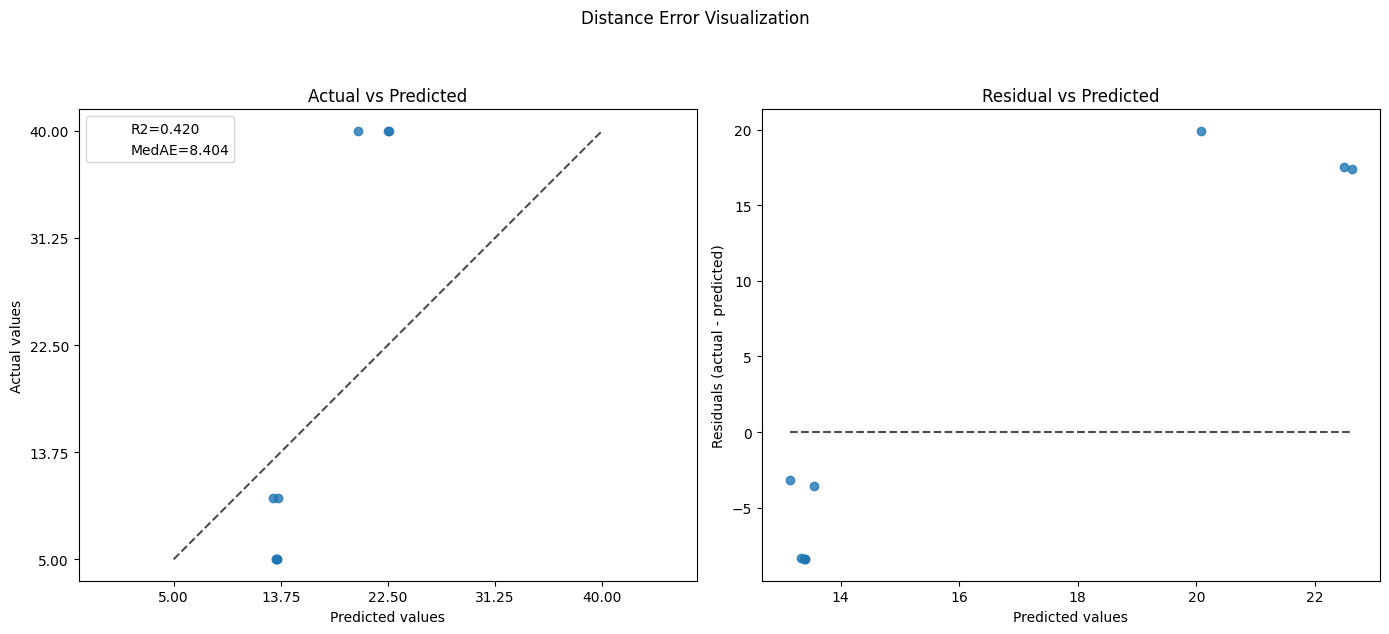

In [92]:
_, _, test_loader = get_classifier_data_loaders(leaks_dataset, BATCH_SIZE)

checkpoint = torch.load(path.join(MODELS_DIR, "RNNClassifier.pth"), weights_only=True)
hparams = checkpoint["hyperparameters"]
print(hparams)
model = RNNClassifier(input_dim=INPUT_DIM, hidden_dim=hparams['hidden_dim'], num_layers=hparams["num_layers"], dropout=hparams["dropout"])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

with torch.no_grad():
  for x, (y_anomaly, y_distance) in test_loader:
    anomaly, distance = model.forward(x)
    
    y_true = y_distance.detach().cpu().numpy()
    y_pred = distance.detach().cpu().numpy()
    
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
    
    actual_vs_predicted = PredictionErrorDisplay.from_predictions(
      y_true, y_pred, ax=ax0, kind="actual_vs_predicted"
    )
    
    residual_vs_predicted = PredictionErrorDisplay.from_predictions(
      y_true, y_pred, kind="residual_vs_predicted", ax=ax1
    )
    
    for name, score in compute_score(y_true, y_pred).items():
        ax0.plot([], [], " ", label=f"{name}={score}")
    ax0.legend(loc="upper left")
      
    ax0.set_title("Actual vs Predicted")
    ax1.set_title("Residual vs Predicted")
    f.suptitle("Distance Error Visualization", y=1.05)
    plt.tight_layout()
  
  